# Pre-processing Data

Address overfitting concerns

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from datetime import datetime
import numpy as np

In [45]:
DM = pd.read_csv('DMChartEvents.csv',usecols=["hadm_id", "subject_id", "itemid", "charttime","valuenum"])
DM = DM.sort_values(by=['charttime'])
Admissions = pd.read_csv('Admissions.csv',index_col=2)
Patients = pd.read_csv('Patients.csv',index_col=1)

In [4]:
hadm_id = []
subject_id = []
for index,row in DM.iterrows():
    if(row['hadm_id'] not in hadm_id):
        hadm_id.append(row['hadm_id'])
        subject_id.append(row['subject_id'])

In [46]:
d = {'hadm_id': hadm_id, 'subject_id': subject_id}
finalDF = pd.DataFrame(data=d)
finalDF['expire_flag'] = 0

In [47]:
for index,row in finalDF.iterrows():
    expire_flag = Admissions.loc[row['hadm_id'],'HOSPITAL_EXPIRE_FLAG']
    finalDF.at[index,'expire_flag'] = expire_flag

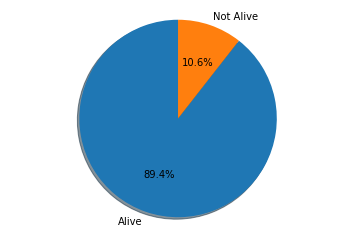

Alive:  12217
Not Alive:  1443


In [48]:
alive = 0
dead = 0
for index,row in finalDF.iterrows():
    if(row['expire_flag'] == 1):
        dead = dead+1
    else:
        alive = alive+1
        
labels = 'Alive', 'Not Alive'
sizes = [alive,dead]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()
print("Alive: ", alive)
print("Not Alive: ", dead)

In [49]:
finalDF['diagnosis'] = ''
for index,row in finalDF.iterrows():
    diagnosis = Admissions.loc[row['hadm_id'],'DIAGNOSIS']
    finalDF.at[index,'diagnosis'] = diagnosis

In [50]:
finalDF['admission_type'] = ''
for index,row in finalDF.iterrows():
    admission_type = Admissions.loc[row['hadm_id'],'ADMISSION_TYPE']
    finalDF.at[index,'admission_type'] = admission_type

In [51]:
finalDF['age'] = 0
for index,row in finalDF.iterrows():
    birth = Patients.loc[row['subject_id'],'DOB']
    birth = datetime.strptime(birth, '%Y-%m-%d %H:%M:%S')
    birth_year = birth.year
    current = Admissions.loc[row['hadm_id'],'ADMITTIME']
    current = datetime.strptime(current, '%Y-%m-%d %H:%M:%S')
    current_year = current.year
    age = current_year-birth_year
    finalDF.at[index,'age'] = age

In [52]:
glucoseNumbers = {}
for index,row in DM.iterrows():
    glucoseNumbers.setdefault(row['hadm_id'], []).append(row['valuenum'])

In [53]:
finalDF['glucose'] = np.array
for index,row in finalDF.iterrows():
    glucose = glucoseNumbers[row['hadm_id']]
    finalDF.at[index,'glucose'] = glucose

In [54]:
from sklearn.preprocessing import LabelEncoder

In [55]:
le_admission_type = LabelEncoder()
finalDF['admission_type_encoded'] = le_admission_type.fit_transform(finalDF.admission_type)

In [56]:
from keras.preprocessing.text import Tokenizer

In [57]:
print(finalDF.head())

   hadm_id  subject_id  expire_flag                diagnosis admission_type  \
0   137275        9319            0        LEFT RENAL CA/SDA       ELECTIVE   
1   125380       31585            0                PNEUMONIA      EMERGENCY   
2   132722        1426            0  LEFT FRONTAL HEMORRHAGE      EMERGENCY   
3   101422       71582            0          AORTIC STENOSIS      EMERGENCY   
4   139687       68501            0     CAROTID STENOSIS/SDA       ELECTIVE   

   age                                            glucose  \
0   82  [167.0, 157.0, 157.0, 143.0, 143.0, 113.0, 113...   
1  300  [127.0, 127.0, 127.0, 113.0, 113.0, 113.0, 133...   
2   80  [172.0, 165.0, 165.0, 154.0, 154.0, 205.0, 205...   
3   76  [140.0, 164.0, 178.0, 109.0, 158.0, 157.0, 139...   
4   86                [251.0, 163.0, 121.0, 180.0, 162.0]   

   admission_type_encoded  
0                       0  
1                       1  
2                       1  
3                       1  
4                 

In [58]:
finalDF.diagnosis = finalDF.diagnosis.astype(str)
tokenizer = Tokenizer(num_words=150)
tokenizer.fit_on_texts(finalDF['diagnosis'])
finalDF['diagnosis_tokenized'] = tokenizer.texts_to_sequences(finalDF['diagnosis'])

In [59]:
#tokenizer.word_index
#print(finalDF.head())

In [60]:
glucose_count = {}
for index,row in finalDF.iterrows():
    glucose_list = row['glucose']
    glucose_count[index] = 0
    for num in glucose_list:
        glucose_count[index] += 1

In [61]:
num_readings = {}

for key,value in glucose_count.items():
    if(value in num_readings):        
        num_readings[value] += 1
    else:
        num_readings[value] = 1
    

In [62]:
num = []
occur = []

for key,value in num_readings.items():
    if(value > 30):
        num.append(key)
        occur.append(value)   

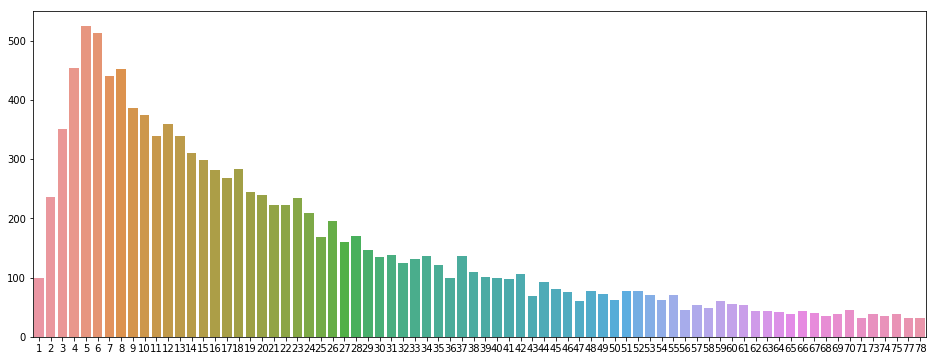

In [63]:
plt.figure(figsize=(16, 6))
ax = sns.barplot(x=num, y=occur)

In [64]:
glucose_dict = {}
for index,row in finalDF.iterrows():
    glucose_list = row['glucose']
    num = index
    if (len(glucose_list) < 10):
        for glu in reversed(glucose_list):        
            glucose_dict.setdefault(num, []).append(glu)  
    else:
        for i in range(1,11):
            glucose_dict.setdefault(num, []).append(glucose_list[(len(glucose_list)-i)])

In [81]:
#print(glucose_dict)

In [66]:
glucoseDF = pd.DataFrame.from_dict(glucose_dict, orient='index')

In [67]:
finalDF = finalDF.join(glucoseDF)

In [68]:
diagnosis_dict = {}
for index,row in finalDF.iterrows():
    diagnosis_list = row['diagnosis_tokenized']
    num = index
    if(len(diagnosis_list) == 0):
        diagnosis_dict.setdefault(num, []).append(-1)  
    for dia in diagnosis_list:        
        diagnosis_dict.setdefault(num, []).append(dia)  

In [69]:
diagnosisDF = pd.DataFrame.from_dict(diagnosis_dict, orient='index')

In [70]:
diagnosisDF.columns = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p']

In [71]:
finalDF = finalDF.join(diagnosisDF)

In [72]:
finalDF = finalDF.drop(columns=['e','f','g','h','i','j','k','l','m','n','o','p'])

In [73]:
finalDF = finalDF.fillna(0)

In [74]:
print(finalDF.head())

   hadm_id  subject_id  expire_flag                diagnosis admission_type  \
0   137275        9319            0        LEFT RENAL CA/SDA       ELECTIVE   
1   125380       31585            0                PNEUMONIA      EMERGENCY   
2   132722        1426            0  LEFT FRONTAL HEMORRHAGE      EMERGENCY   
3   101422       71582            0          AORTIC STENOSIS      EMERGENCY   
4   139687       68501            0     CAROTID STENOSIS/SDA       ELECTIVE   

   age                                            glucose  \
0   82  [167.0, 157.0, 157.0, 143.0, 143.0, 113.0, 113...   
1  300  [127.0, 127.0, 127.0, 113.0, 113.0, 113.0, 133...   
2   80  [172.0, 165.0, 165.0, 154.0, 154.0, 205.0, 205...   
3   76  [140.0, 164.0, 178.0, 109.0, 158.0, 157.0, 139...   
4   86                [251.0, 163.0, 121.0, 180.0, 162.0]   

   admission_type_encoded diagnosis_tokenized      0 ...       4      5  \
0                       0     [26, 24, 85, 4]  118.0 ...    90.0   88.0   
1       

In [75]:
finalDF.to_csv('finalDF.csv', mode='w')

In [80]:
full = 0
not_full = 0
for index,row in finalDF.iterrows():
    if(row[20] == 0):
        not_full += 1
    else:
        full += 1
print('full: ',full)
print('not_full: ',not_full)
        

full:  9105
not_full:  4555
